In [62]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations

In [63]:
p_mlp_single = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/condition/balanced/connectomes'
p_mlp_pairs = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/mlp'

p_cnn_single = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/cnn/single'
p_cnn_pairs = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/cnn'

p_concat_single = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/concat/single'
p_concat_pairs = '/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/concat'

prefix = None
path_out = ''

cases = ['SZ',
            'ASD',
            'BIP',
            'DEL22q11_2',
            'DUP22q11_2',
            'DEL16p11_2',
            'DUP16p11_2',
            'DEL1q21_1',
            'DUP1q21_1']

case_to_idx = dict(zip(cases,range(len(cases))))

# MLP
## Load Single Task Results

In [64]:
mlp_single = np.zeros(len(cases))
for case in cases:
    p = os.path.join(p_mlp_single,f'{case}')
    final_acc = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        file = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0]
        df = pd.read_csv(os.path.join(p,f'fold_{i}',file),index_col=0,header=[0,1])[case]
        final_acc.append(df['Accuracy/test'].iloc[-1])
    mlp_single[case_to_idx[case]] = np.mean(final_acc)

## Load Pair Results

In [65]:
pairs = [combo for combo in combinations(cases,2)]
mlp_pairs = np.zeros((len(cases),len(cases)))

In [66]:
for i in range(1,len(pairs)+1):
    p = os.path.join(p_mlp_pairs,f'pair_{i}')
    p_fold = os.path.join(p,'fold_0')
    case1 = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0].split('.')[0].split('-')[2]
    case2 = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0].split('.')[0].split('-')[3]
    final_acc_case1 = []
    final_acc_case2 = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        file = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0]
        df = pd.read_csv(os.path.join(p_fold,file),index_col=0,header=[0,1])
        final_acc_case1.append(df[case1]['Accuracy/test'].iloc[-1])
        final_acc_case2.append(df[case2]['Accuracy/test'].iloc[-1])
    
    # case1, case2: accuracy of case1 trained with case2
    # case2, case1: accuracy of case2 trained with case1
    mlp_pairs[case_to_idx[case1],case_to_idx[case2]] = np.mean(final_acc_case1)
    mlp_pairs[case_to_idx[case2],case_to_idx[case1]] = np.mean(final_acc_case2)

np.fill_diagonal(mlp_pairs,mlp_single)

<AxesSubplot: >

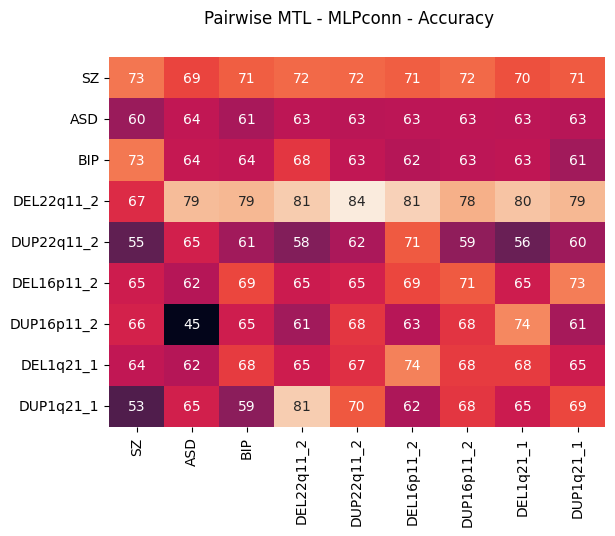

In [67]:
plt.suptitle('Pairwise MTL - MLPconn - Accuracy')
sns.heatmap(mlp_pairs,xticklabels=cases,yticklabels=cases,annot=True,cbar=False)

Text(0.5, 0.98, 'Pairwise MTL - MLPconn - Diff from Baseline')

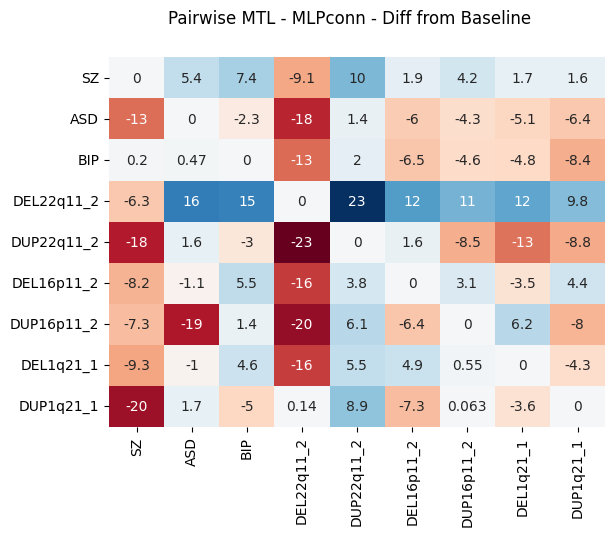

In [68]:
sns.heatmap(mlp_pairs - mlp_single,xticklabels=cases,yticklabels=cases,annot=True,cmap='RdBu',cbar=False)
plt.suptitle('Pairwise MTL - MLPconn - Diff from Baseline')

# CNN
## Load Single Task Results

In [69]:
cnn_single = np.zeros(len(cases))
for case in cases:
    p = os.path.join(p_cnn_single,f'{case}')
    final_acc = []
    for i in range(5):
        p_fold = os.path.join(p,f'fold_{i}')
        file = [f for f in os.listdir(p_fold) if f[-4:]=='.csv'][0]
        df = pd.read_csv(os.path.join(p,f'fold_{i}',file),index_col=0,header=[0,1])[case]
        final_acc.append(df['Accuracy/test'].iloc[-1])
    cnn_single[case_to_idx[case]] = np.mean(final_acc)

IndexError: list index out of range

In [70]:
p

'/Users/harveyaa/Documents/masters/neuropsych_mtl/MTL/results/neg_transfer/cnn/single/SZ'